###Khan Academy Infection

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import numpy as np
%matplotlib inline

###Part 1: Total Infection

Here we assume that students are only connected to their coaches and coaches are only connected to their students. Thus, while we could model the coaching relationships via a directed graph, for purposes of the infection we model this as a undirected graph. We know that:
1. If B coaches C, then C should get the new feature as well. 
2. Infections are transferred by both the “coaches” and “is coached by” relations.

Thus, if someone is infected, so is everyone he/she is connected to in the graph. This is the case recursively until we have all the nodes in an entire connected component infected.

In [2]:
def total_infection(user, network):
    """ infect every node in the connected component containing the user specified"""
    """ takes an undirected graph as input """
    try:
        #infect the user
        network.node[user]['infected'] = True
    except:
        raise ValueError("User is not in the network.")
    neighbors = network.neighbors(user)
    for neighbor in neighbors:
        # only run total_infection() on uninfected neighbors; otherwise, infinite loop
        if network.node[neighbor]['infected'] == False:
            total_infection(neighbor, network)

###Part 2: Limited Infection

We need to satisfy two criteria to make an effective limited_infection(). First, we want to make sure we have appropriate-sized group(s) to roll out a feature. Second, we want to make sure we are not harming users' experiences and thus want to keep all connected components intact (i.e. all users in a connected component either have or do not have the infection).

We imagine the graph of our users to look like a graph made of several distinct connected components (with the exception of a graph where all the users are connected; however, as specified in the prompt, this is pretty unrealistic). We want to find a connected component or combination of connected components that sum up to a specific value we dictate. The algorithm works as follows:

1. We iterate through every connected component and measure each of their sizes (i.e.the number of nodes, or users). If any one component has as many nodes as the number we want to infect, we infect all the nodes in that component.
2. If none of the individual components has the exact size, we then look at combinations of components. We do this by sorting the components by size and combining the as such:

    [1,2,3] #list of component sizes<br />
    We combine them in the following way:<br />
    [[1]]<br />
    [[1],[1,2],[2]]<br />
    [[1],[1,2],[2],[1,3],[1,2,3],[2,3],[3]]<br />
    
At every point in Step 1 and 2, we check to see if the connected component or combination of connected components is equal to the infection size. If so, we infect the nodes in all the connected component(s). If we have iterated through all the connected components and possible combinations and none of these sums is equal to the value we want, the function does nothing and returns "Not able to infect exact number of users."

In [2]:
def _find_connected_component(cmpts, user, network):
    """works recursively to find all the nodes in the connected component"""
    cmpts.append(user)
    neighbors = network.neighbors(user)
    for neighbor in neighbors:
        if neighbor not in cmpts:
            cmpts = _find_connected_component(cmpts,neighbor, network)
    return cmpts
        
    
def _add_to_sub_sums(num, sub_sums, infect_num):
    """ if a combination summing to the infection size is found, return the component sizes
    else, return a list of lists (i.e. sub_sums) with a new list element (i.e. subsequence of 
    connected components) appended """
    #list of the new subsequences of connected components to append to sub_sums
    new_combinations = []
    for sub_sum in sub_sums:
        #if the combination does sum up to the infection size, return the component sizes
        if sum(sub_sum) + num == infect_num:
            return [sub_sum+[num]]
        #else, only add the combination if the sum of the sub_sum list plus num is 
        #less than our desired infection size
        elif sum(sub_sum)+num < infect_num:
            new_sub_sum = sub_sum + [num]
            new_combinations.append(new_sub_sum)
    for comb in new_combinations:
        sub_sums.append(comb)
    return sub_sums


def _infect_cmpt(network, cmpts_list, num_list, num):
    """infect a connected component given its size (i.e. number of nodes) """
    cmpts_to_infect = cmpts_list[num_list.index(num)]
    nx.set_node_attributes(network, "infected", 
                           dict(zip(cmpts_to_infect, np.repeat(True,len(cmpts_to_infect)))))

def limited_infection(infect_num, network):
    """ This function finds all connected components and their sizes
    then infects an exact number 'infect_num' of nodes. If it can't find
    one component of that size, it finds an appropriate combination of 
    connected components to  infect (specifically, the first combination 
    that works) """
    ### Setup
    
    #get all nodes in the network
    all_nodes = network.nodes()
    #get network length
    network_length = len(all_nodes)
    if infect_num > network_length:
        raise ValueError("The infection size exceeds the network length.")
    #start with a random user
    random_user = np.random.choice(all_nodes)
    #find the user's corresponding connected component
    cmpts = _find_connected_component([],random_user, network)
    #this is a list of lists for the connected components
    cmpts_list = [cmpts]
    #this is the number of nodes in the connected component
    num_cmpts = len(cmpts)
    #this is a list for the sizes (i.e. number of nodes) of the connected components
    num_list = [num_cmpts]
    #this counter keeps track of how many nodes we have already looked at
    num_tested = num_cmpts
    #if the size of the component is exactly the infection size, infect the component
    if num_cmpts == infect_num:
        _infect_cmpt(network, cmpts_list, num_list, num_cmpts)
        return "Successfully infected single component of size %s." % infect_num
    
    ### Step 1: find all the connected components in the network
    
    while num_tested < network_length:
        #flatten the list of lists to a list to iterate
        flattened_list = [cmpt for cmpts in cmpts_list for cmpt in cmpts]
        #find a random user from another component of the network not already looked at
        while random_user in flattened_list:
            random_user = np.random.choice(list(set(all_nodes) - set(flattened_list)))
        #find the connectd component the user belongs to
        cmpts = _find_connected_component([],random_user, network)
        num_cmpts = len(cmpts)
        #append the connected components and their sizes to the list
        cmpts_list.append(cmpts)
        num_list.append(num_cmpts)
        #if the size of the component is exactly the infection size, infect the component
        if num_cmpts == infect_num:
            _infect_cmpt(network, cmpts_list, num_list, num_cmpts)
            return "Successfully infected single component of size %s." % infect_num
        #increase the counter keeping track of the nodes accounted for in the iterations
        num_tested +=num_cmpts
    
    ### Step 2: iterate through combinations of connected components 
    ### to find one that satisfies the constraints
    
    #define an empty list of the cmpts
    cmpt_list_to_infect = []
    sorted_num_list = sorted(num_list)
    #sub_sums will be a list of lists containing the various combinations of 
    #components to add together
    sub_sums = []
    #iterate through each connected component size
    for num in sorted_num_list:
        #if the connected component size is greater than the infection size we want,
        #so must every subsequent component
        if num > infect_num:
            break
        #for each component size (i.e. num)
        #add to sub_sum the lists of every existing combination plus num 
        if sub_sums:
            sub_sums = _add_to_sub_sums(num, sub_sums, infect_num)
            #if _add_to_sub_sums() returns the exact combination summing to the 
            #infection size, infect those connected components
            if len(sub_sums) == 1:
                for num in sub_sums[0]:
                    _infect_cmpt(network, cmpts_list, num_list, num)
                return "Successfully infected multiple components of summed size %s." % infect_num
        #add num by itself as a combination to sub_sum
        sub_sums.append([num])
    #if out of the loop, there is no combination summing exactly to the infection sum
    return "Not able to infect exact number of users."                                

###Optional Part 3: Visualization

The following is a visualization of the network after the implementation of full_infection(). This visualization uses the Fruchterman-Reingold force-directed algorithm, where the red nodes denote infected and green nodes unaffected.

In [3]:
def visualize_infected_network(network, networka):
    """ here we use information from both the pre-infection directed graph
        and the post-infection undirected graph, taking the node data from 
        networka (post-infection) and the edge data from network (pre-infection)"""
    #Position nodes using Fruchterman-Reingold force-directed algorithm
    pos=nx.spring_layout(networka)

    node_color = []
    #determine the sequence of colors for the nodes
    for node in networka.nodes(data=True):
        #infected nodes are red
        if node[1]['infected']:
            node_color.append('r')
        #uninfected nodes are green
        else:
            node_color.append('g')

    nx.draw_networkx_nodes(networka, pos,node_color=node_color)
    nx.draw_networkx_edges(network,pos,arrows=True)

    #disregard matplotlib warning (known issue)
    import warnings
    warnings.filterwarnings("ignore")
    
    plt.axis('off')
    plt.title('Visualization of the test network after infection')

    #create a legend
    infected_lab = mpatches.Patch(color='red', label='infected')
    unaffected_lab = mpatches.Patch(color='green', label='unaffected')
    plt.legend(handles=[infected_lab, unaffected_lab], loc=0)

Here we visualize an infected network after a call to total_infection().

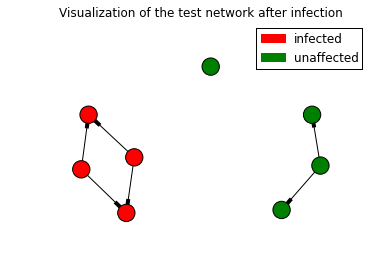

In [14]:
#Create a directed graph to model the coaching relationships (for use in the visualizations)
network=nx.DiGraph()
network.add_nodes_from(["A","B","C"], infected=False)
network.add_nodes_from(['a','b','c','d','e'], infected=False)
network.add_edges_from([("A",'b'), ('A','c'), ("B",'b'),("B",'c'),("C",'d'),("C",'e')])
#create a deep copy of an undirected graph for use in the function total_infection()
networka = network.to_undirected()
total_infection("A",networka)
#expect "A", "B", 'b', 'c' to be infected
visualize_infected_network(network, networka)

Here we visualize an infected network after a call to limited_infection().

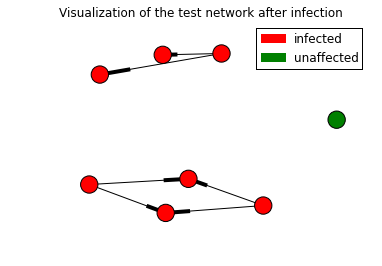

In [4]:
network1=nx.DiGraph()
network1.add_nodes_from(["A","B","C"], infected=False)
network1.add_nodes_from(['a','b','c','d','e'], infected=False)
network1.add_edges_from([("A",'b'), ('A','c'), ("B",'b'),("B",'c'),("C",'d'),("C",'e')])
network1a = network1.to_undirected()
limited_infection(7,network1a)
#expect all nodes except 'a' to be infected
visualize_infected_network(network1, network1a)

###To do with extra time

If I were to spend more time, I would:

1. Improve the algorithm in limited_infection() to be more efficient and also allow leeway from the exact threshold. In the end, the purpose of limited infection for A/B testing is not necessarily to infect an exact number of users, but to get roughly appropriate sizes for the treatment and control groups. 
2. Oftentimes, we want to test not just one feature, but multiple versions of that specific feature (if, for example, the infection is used to test out multiple versions of a feature). Thus, I would also like to create a new version of limited_infection() that allows for this so that one would be able to conduct multiple comparisons.
3. Make the arrows in the visualizations more nice-looking, since they are currently just stubs. I would also look into generating larger, possibly randomly-generated graphs to play around with in my visualizations.